In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV

In [21]:
target = 'SalePrice'

def read_data(test_set=False):
    '''
    Read data from CSV
    
    Parameters
        test_set (bool): read only test set
    Returns
        X (n x m dataframe), y (n x 2 dataframe) <- returned only for train set
    '''
    if test_set:
        return pd.read_csv('test.csv')
        
    data = pd.read_csv('train.csv')

    return data.drop(columns=[target]), data[['Id', target]]

def null_cols(d):
    '''
    Find columns that have at least one null value
    
    Parametrs
        d (dataframe): dataframe with multiple columns
    Returns
        num_cols (series): column names and their percentage of
            observations with NaN for the column
    '''
    cols = d.columns[d.isnull().any()].to_numpy()

    return np.round(np.sum(d[cols].isnull()) / len(d), 2).sort_values()

def plot_against_target(X, y, col):
    '''
    Plot X[col] against y['SalePrice']

    Parameters
        X (dataframe): containing `col`
        y (dataframe): container `SalePrice`
    '''
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(X[col].fillna('None'), y[target] / 1000)
    ax.set_title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

def preprocess(d):
    cols_to_drop = ['PoolQC', 'MiscFeature', 'MiscVal', 'MoSold']
    
    d_ = d.copy()
    d_ = d_.drop(columns=cols_to_drop)

    null_num_cols = null_cols(d_.select_dtypes('number')).index
    d_[null_num_cols] = d_[null_num_cols].fillna(0.0)
    
    null_cat_cols = null_cols(d_.select_dtypes('object')).index
    d_[null_cat_cols] = d_[null_cat_cols].fillna(0.0)

    return d_


In [22]:
X_train, y_train = read_data()
X_train[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


<pre>
PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64
</pre>

- replace NaN with 'NoPool' in PoolQC. Very few houses have pools. Houses with NaN already have 0 for PoolArea
  - but no correlation with target. So REMOVE it

<pre>
MiscFeature
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64
</pre>

- replace NaN with 'None' in MiscFeature.
  - But correlation with target is not very clear. So REMOVE it (But check again while fitting)
  - MiscValue is related to MiscFeature. REMOVE it
 
<pre>
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64
</pre>

- same as above for Alley
- MoSold has a high p-value and no correlation with target. REMOVE it

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 'GrLivArea' 'BsmtUnfSF' 'BsmtFinSF1', 'BsmtFinSF2'
c = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'YrSold']

X = preprocess(X_train).select_dtypes('number')
X = X[c]
# the calculation of variance inflation requires a constant
X['intercept'] = 1

# create dataframe to store vif values
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif[vif['Variable']!='intercept']
vif

,Variable,VIF
0,Id,1.025686
1,MSSubClass,1.538457
2,LotFrontage,1.195429
3,LotArea,1.214212
4,OverallQual,3.222461
5,OverallCond,1.566371
6,YearBuilt,4.065477
7,YearRemodAdd,2.248601
8,MasVnrArea,1.383878
9,TotalBsmtSF,3.848499


In [24]:
# plt.scatter(X_train['Lot_Frontage'], y_train['Sale_Price'])
import statsmodels.api as sm

num_cols = preprocess(X_train).select_dtypes('number')
X2 = sm.add_constant(num_cols)
ols = sm.OLS(y_train['SalePrice'], X2)
res = ols.fit()

In [25]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     192.2
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        07:19:40   Log-Likelihood:                -17307.
No. Observations:                1460   AIC:                         3.468e+04
Df Residuals:                    1426   BIC:                         3.486e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.596e+05   1.38e+06      0.332      0.740   -2.26e+06    3.17e+06
Id               -1.0533      2.165     -0.486      0.627      -5.301       3.194
MSSubClass     -166.8902     26.433     -6.314      0.000    -218.742    -115.039
LotFrontage       9.3117     28.432      0.328      0.743     -46.461      65.085
LotArea           0.3907      0.100      3.918      0.000       0.195       0.586
OverallQual     1.73e+04   1176.533     14.705      0.000     1.5e+04    1.96e+04
OverallCond    5098.9031   1019.871      5.000      0.000    3098.295    7099.511
YearBuilt       337.7475     60.341      5.597      0.000     219.380     456.115
YearRemodAdd    121.9718     65.975      1.849      0.065      -7.447     251.391
MasVnrArea       28.1242      5.911      4.758      0.000      16.530      39.719
BsmtFinSF1        9.5299      2.505      3.804      0.000       4.616      14.444
BsmtFinSF2        0.0755      4.470      0.017      0.987      -8.693       8.844
BsmtUnfSF        -0.5518      2.392     -0.231      0.818      -5.243       4.140
TotalBsmtSF       9.0536      3.336      2.714      0.007       2.509      15.598
1stFlrSF         18.6842      6.083      3.072      0.002       6.752      30.616
2ndFlrSF         19.8685      5.635      3.526      0.000       8.815      30.922
LowQualFinSF    -10.3367     14.710     -0.703      0.482     -39.191      18.518
GrLivArea        28.2161      5.626      5.015      0.000      17.180      39.252
BsmtFullBath   8577.1187   2590.107      3.311      0.001    3496.290    1.37e+04
BsmtHalfBath   1721.4513   4047.507      0.425      0.671   -6218.256    9661.159
FullBath       3241.8530   2798.219      1.159      0.247   -2247.214    8730.920
HalfBath      -1895.5209   2638.064     -0.719      0.473   -7070.423    3279.381
BedroomAbvGr  -1.027e+04   1676.685     -6.123      0.000   -1.36e+04   -6977.874
KitchenAbvGr  -1.589e+04   5168.904     -3.075      0.002    -2.6e+04   -5754.913
TotRmsAbvGrd   4997.0185   1224.133      4.082      0.000    2595.723    7398.314
Fireplaces     4066.1339   1755.572      2.316      0.021     622.353    7509.915
GarageYrBlt     -14.5777      2.681     -5.437      0.000     -19.837      -9.318
GarageCars     1.572e+04   2969.449      5.293      0.000    9891.664    2.15e+04
GarageArea        4.9587      9.706      0.511      0.610     -14.082      23.999
WoodDeckSF       25.7775      7.917      3.256      0.001      10.246      41.309
OpenPorchSF      -6.3274     15.023     -0.421      0.674     -35.797      23.142
EnclosedPorch    11.5842     16.688      0.694      0.488     -21.151      44.319
3SsnPorch        20.0662     31.097      0.645      0.519     -40.934      81.067
ScreenPorch      57.5057     17.012      3.380      0.001      24.134      90.878
PoolArea        -32.2095     23.483     -1.372   

In [7]:
preprocess(X_train).select_dtypes('number').shape

(1460, 37)

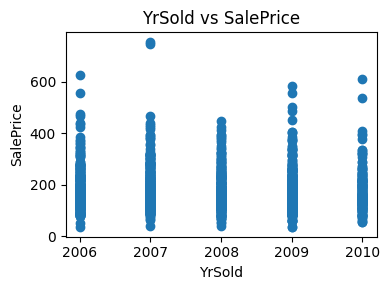

In [20]:
plot_against_target(X_train, y_train, 'YrSold')